In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [16]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, W1, W2, W3, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), W1 = cpu(W1), W2 = cpu(W2), W3 = cpu(W3)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    W1 = randn(500,20)
    W2 = randn(500,500)
    W3 = randn(784,500)

    return encoder_μ, encoder_logvar, W1, W2, W3
end

function active_weights(W,z)
    return diagm(Int.((W*z) .> 0))*W
end



active_weights (generic function with 1 method)

In [15]:
diagm(Int.(randn(4) .> 0))

4×4 Matrix{Int64}:
 0  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

In [50]:
function vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample

    x̂ = W3*relu(W2*relu(W1*z))

    loss_α = norm(F*x̂, Inf) + norm(x̂)^2
    # loss_α(F,A) = maximum(sqrt.(sum((F*A).*(F*A), dims = 2))) + norm(A'*A - I(500),2)^2
    # α = loss_α(F, W3)
    
    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(logitbinarycrossentropy.(x̂, x)) 
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, W1, W2, W3))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg + 1000 * loss_α #+Flux.mse(x̂, x) 
end

function train(encoder_μ, encoder_logvar, W1, W2, W3, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, W1, W2, W3)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, W1, W2, W3, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [52]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 50
save_dir = "trained_GNN/MNIST_identity_v3"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, W1, W2, W3 = create_vae()
train(encoder_μ, encoder_logvar, W1, W2, W3, dataloader, num_epochs, λ, β, ADAM(η), save_dir)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:187


Saving model...Done


Training a epoch done   4%|█▎                            |  ETA: 0:53:54


Saving model...Done



Training a epoch done   6%|█▊                            |  ETA: 0:53:33


Saving model...Done



Training a epoch done   8%|██▍                           |  ETA: 0:52:48


Saving model...Done



Training a epoch done  10%|███                           |  ETA: 0:51:49


Saving model...Done



Training a epoch done  12%|███▋                          |  ETA: 0:50:47


Saving model...Done



Training a epoch done  14%|████▎                         |  ETA: 0:49:42


Saving model...Done



Training a epoch done  16%|████▊                         |  ETA: 0:48:34


Saving model...Done



Training a epoch done  18%|█████▍                        |  ETA: 0:47:26


Saving model...Done



Training a epoch done  20%|██████                        |  ETA: 0:46:15


Saving model...Done



Training a epoch done  22%|██████▋                       |  ETA: 0:45:04


Saving model...Done



Training a epoch done  24%|███████▎                      |  ETA: 0:43:54


Saving model...Done



Training a epoch done  26%|███████▊                      |  ETA: 0:42:42


Saving model...Done



Training a epoch done  28%|████████▍                     |  ETA: 0:41:31


Saving model...Done



Training a epoch done  30%|█████████                     |  ETA: 0:40:24


Saving model...Done



Training a epoch done  32%|█████████▋                    |  ETA: 0:39:15


Saving model...Done



Training a epoch done  34%|██████████▎                   |  ETA: 0:38:06


Saving model...Done



Training a epoch done  36%|██████████▊                   |  ETA: 0:37:00


Saving model...Done



Training a epoch done  38%|███████████▍                  |  ETA: 0:35:57


Saving model...Done



Training a epoch done  40%|████████████                  |  ETA: 0:34:53


Saving model...Done



Training a epoch done  42%|████████████▋                 |  ETA: 0:33:47


Saving model...Done


Training a epoch done  44%|█████████████▎                |  ETA: 0:32:41


Saving model...Done



Training a epoch done  46%|█████████████▊                |  ETA: 0:31:35


Saving model...Done



Training a epoch done  48%|██████████████▍               |  ETA: 0:30:28


Saving model...Done



Training a epoch done  50%|███████████████               |  ETA: 0:29:21


Saving model...Done



Training a epoch done  52%|███████████████▋              |  ETA: 0:28:13


Saving model...Done



Training a epoch done  54%|████████████████▎             |  ETA: 0:27:05


Saving model...Done



Training a epoch done  56%|████████████████▊             |  ETA: 0:25:57


Saving model...Done



Training a epoch done  58%|█████████████████▍            |  ETA: 0:24:48


Saving model...Done



Training a epoch done  60%|██████████████████            |  ETA: 0:23:39


Saving model...Done



Training a epoch done  62%|██████████████████▋           |  ETA: 0:22:30


Saving model...Done



Training a epoch done  64%|███████████████████▎          |  ETA: 0:21:20


Saving model...Done



Training a epoch done  66%|███████████████████▊          |  ETA: 0:20:11


Saving model...Done


Training a epoch done  68%|████████████████████▍         |  ETA: 0:19:01


Saving model...Done



Training a epoch done  70%|█████████████████████         |  ETA: 0:17:51


Saving model...Done



Training a epoch done  72%|█████████████████████▋        |  ETA: 0:16:40


Saving model...Done



Training a epoch done  74%|██████████████████████▎       |  ETA: 0:15:30


Saving model...Done



Training a epoch done  76%|██████████████████████▊       |  ETA: 0:14:19


Saving model...Done



Training a epoch done  78%|███████████████████████▍      |  ETA: 0:13:09


Saving model...Done


Training a epoch done  80%|████████████████████████      |  ETA: 0:11:58


Saving model...Done



Training a epoch done  82%|████████████████████████▋     |  ETA: 0:10:46


Saving model...Done



Training a epoch done  84%|█████████████████████████▎    |  ETA: 0:09:35


Saving model...Done


Training a epoch done  86%|█████████████████████████▊    |  ETA: 0:08:23


Saving model...Done



Training a epoch done  88%|██████████████████████████▍   |  ETA: 0:07:12


Saving model...Done



Training a epoch done  90%|███████████████████████████   |  ETA: 0:06:00


Saving model...Done


Training a epoch done  92%|███████████████████████████▋  |  ETA: 0:04:48


Saving model...Done



Training a epoch done  94%|████████████████████████████▎ |  ETA: 0:03:36


Saving model...Done



Training a epoch done  96%|████████████████████████████▊ |  ETA: 0:02:24


Saving model...Done


Training a epoch done  98%|█████████████████████████████▍|  ETA: 0:01:12


Saving model...Done


Training a epoch done 100%|██████████████████████████████| Time: 1:00:14
  loss:  7.309778984706148e6


Saving model...Done
Training complete!


In [39]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = W3*relu(W2*relu(W1*z))
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 30
    epoch_to_load = 10
    # Load the model and test set loader
    dir = "trained_GNN/MNIST_identity_v3"
    encoder_μ, encoder_logvar, W1, W2, W3 = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, x_batch)
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [32]:
visualise()

Loading model...Done

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


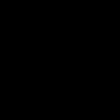

In [47]:
load("trained_GNN/MNIST_identity_v3/reconstruction-3.png")

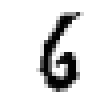

In [46]:
load("trained_GNN/MNIST_identity_v3/test-image-3.png")

In [49]:
using NBInclude
# @nbinclude("functions.ipynb")
epoch_to_load = 10
# Load the model and test set loader
dir = "trained_GNN/MNIST_identity_v3"
encoder_μ, encoder_logvar, W1, W2, W3 = load_model_identity(dir, epoch_to_load)

encoder_μ, encoder_logvar, W1, W2, W3 = load_model_identity(dir, epoch_to_load)
colorview(Gray, reshape(W3 *relu(W2*relu(W1*randn(20))), 28,28)' )
F = dct(diagm(ones(784)),2);
subspace_incoherence(F,W3)




Loading model...Done
Loading model...Done


0.83936656508111

In [ ]:
x_dim = 400
k = 10
F = dct(diagm(ones(x_dim)),2);
A = sample_fourier(k,x_dim); A = A'
print(A[1,1])
function loss(F,A)
    maximum(sqrt.(sum((A'*F').*(A'*F'), dims = 1))) + norm(A'*A - I(k),2)^2
end
θ = Flux.params(A)
# gs = gradient(()->loss(F), θ)
# Flux.Optimise.update!(opt, A, gs[A]);

opt = Descent(.1)
for i in 1:100
    gs = gradient(()->loss(F,A), A)
    Flux.Optimise.update!(opt, A, gs[A]);
    # A = A + randn(400,10)*.5^i
    # θ = Flux.params(A)

end

gs[A]
